In [1]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
img_height,img_width=(224,224)
batch_size=32

train_data_dir= r"/content/drive/My Drive/flowers_dataset/processed_data/train"
valid_data_dir = r"/content/drive/My Drive/flowers_dataset/processed_data/val"
test_data_dir= r"/content/drive/My Drive/flowers_dataset/processed_data/test"

In [4]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split=0.4)
train_generator=train_datagen.flow_from_directory(train_data_dir,target_size=(img_height,img_width),batch_size=batch_size,class_mode='categorical',subset='training')
valid_generator=train_datagen.flow_from_directory(valid_data_dir,target_size=(img_height,img_width),batch_size=batch_size,class_mode='categorical',subset='validation')

Found 1554 images belonging to 5 classes.
Found 342 images belonging to 5 classes.


In [5]:
test_generator=train_datagen.flow_from_directory(test_data_dir,target_size=(img_height,img_width),batch_size=1,class_mode='categorical',subset='validation')

Found 346 images belonging to 5 classes.


In [6]:
x,y=test_generator.next()
x.shape

(1, 224, 224, 3)

In [7]:
base_model=ResNet50(include_top=False,weights='imagenet')
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
predictions= Dense(train_generator.num_classes,activation='softmax')(x)
model = Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
  layer.trainable=False


94781440/94765736 [==============================] - 1s 0us/step


In [8]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
model.fit(train_generator,epochs=10)

Epoch 1/10
49/49 [==============================] - 332s 7s/step - loss: 0.7391 - accuracy: 0.7741
Epoch 2/10
49/49 [==============================] - 259s 5s/step - loss: 0.2261 - accuracy: 0.9260
Epoch 3/10
49/49 [==============================] - 263s 5s/step - loss: 0.1704 - accuracy: 0.9395
Epoch 4/10
49/49 [==============================] - 261s 5s/step - loss: 0.1075 - accuracy: 0.9659
Epoch 5/10
49/49 [==============================] - 262s 5s/step - loss: 0.0891 - accuracy: 0.9678
Epoch 6/10
49/49 [==============================] - 255s 5s/step - loss: 0.0961 - accuracy: 0.9672
Epoch 7/10
49/49 [==============================] - 255s 5s/step - loss: 0.0522 - accuracy: 0.9839
Epoch 8/10
49/49 [==============================] - 254s 5s/step - loss: 0.0693 - accuracy: 0.9717
Epoch 9/10
49/49 [==============================] - 254s 5s/step - loss: 0.0527 - accuracy: 0.9858
Epoch 10/10
49/49 [==============================] - 254s 5s/step - loss: 0.0250 - accuracy: 0.9923


In [10]:
model.save('/content/drive/My Drive/flowers_dataset/saved_model/ResNet50.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [11]:
test_loss,test_acc=model.evaluate(test_generator,verbose=2)
print("\nTest Accuracy: ",test_acc)

346/346 - 78s - loss: 0.4082 - accuracy: 0.9046

Test Accuracy:  0.9046242833137512


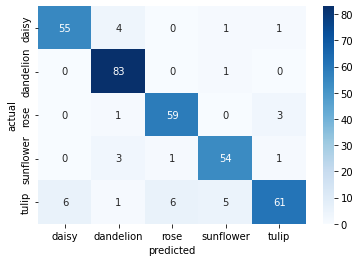

Test Accuracy: 90.17341040462428 


In [15]:
import pandas as pd
import seaborn as sn
import tensorflow as tf
model=tf.keras.models.load_model("/content/drive/My Drive/flowers_dataset/saved_model/ResNet50.h5")
filenames=test_generator.filenames
nb_samples=len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  x_test,y_test=test_generator.next()
  y_prob.append(model.predict(x_test))
  y_act.append(y_test)

predicted_class=[list(train_generator.class_indices.keys()) [i.argmax()] for i in y_prob]
actual_class=[list(train_generator.class_indices.keys()) [i.argmax()] for i in y_act]

out_df=pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix=pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['actual'],colnames=['predicted'])
sn.heatmap(confusion_matrix,cmap='Blues',annot=True,fmt='d')
plt.show()
print('Test Accuracy: {} '.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))